## Lê Thành Danh: EXPLORATORY DATA ANALYSIS & CLUSTERING - PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA) & PHÂN CỤM


### 1. Khai báo thư viện

In [27]:
# 1. Khai báo thư viện

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

### 2. Tải dữ liệu

In [28]:
# 2. Tải dữ liệu
print("PHẦN 2: Phân tích phân cụm (Clustering Analysis)")

df = pd.read_csv('data/cleaned_data.csv')
print(f"\n Đã load cleaned data: {df.shape[0]:,} rows × {df.shape[1]} columns")

PHẦN 2: Phân tích phân cụm (Clustering Analysis)

 Đã load cleaned data: 99,457 rows × 29 columns


### 3. Chuẩn bị dữ liệu cho clustering

In [29]:
if all(col in df.columns for col in ['recency', 'age', 'monetary']):
    # Aggregate theo customer_id
    ram_df = df.groupby('customer_id').agg({
        'recency': 'min',
        'age': 'max',
        'monetary': 'sum'
    }).reset_index()
    
    print(f"Số khách hàng: {len(ram_df):,}")
    print(f"Features: Recency, Age, Monetary")
    
    # Chuẩn hóa RAM
    scaler = StandardScaler()
    ram_scaled = scaler.fit_transform(ram_df[['recency', 'age', 'monetary']])
    
    print("RAM Statistics:")
    print(ram_df[['recency', 'age', 'monetary']].describe())

Số khách hàng: 99,457
Features: Recency, Age, Monetary
RAM Statistics:
            recency           age      monetary
count  99457.000000  99457.000000  99457.000000
mean     396.884030     43.427089   2528.789268
std      229.871351     14.990054   4222.475781
min        0.000000     18.000000      5.230000
25%      198.000000     30.000000    136.350000
50%      396.000000     43.000000    600.170000
75%      597.000000     56.000000   2700.720000
max      796.000000     69.000000  26250.000000


### 4. Phương pháp phân cụm 1: K-Means

#### 4.1. Phương pháp Elbow - Tìm k tối ưu

1. Phương pháp Elbow - Tìm k tối ưu:
k=2, WCSS=223814.41, Silhouette=0.2715
k=3, WCSS=167339.58, Silhouette=0.2974
k=4, WCSS=125276.14, Silhouette=0.3122
k=5, WCSS=97211.73, Silhouette=0.3216
k=6, WCSS=85016.79, Silhouette=0.3274
k=7, WCSS=77220.62, Silhouette=0.3323
k=8, WCSS=70961.07, Silhouette=0.3139
k=9, WCSS=65853.43, Silhouette=0.2947
k=10, WCSS=60695.14, Silhouette=0.3179


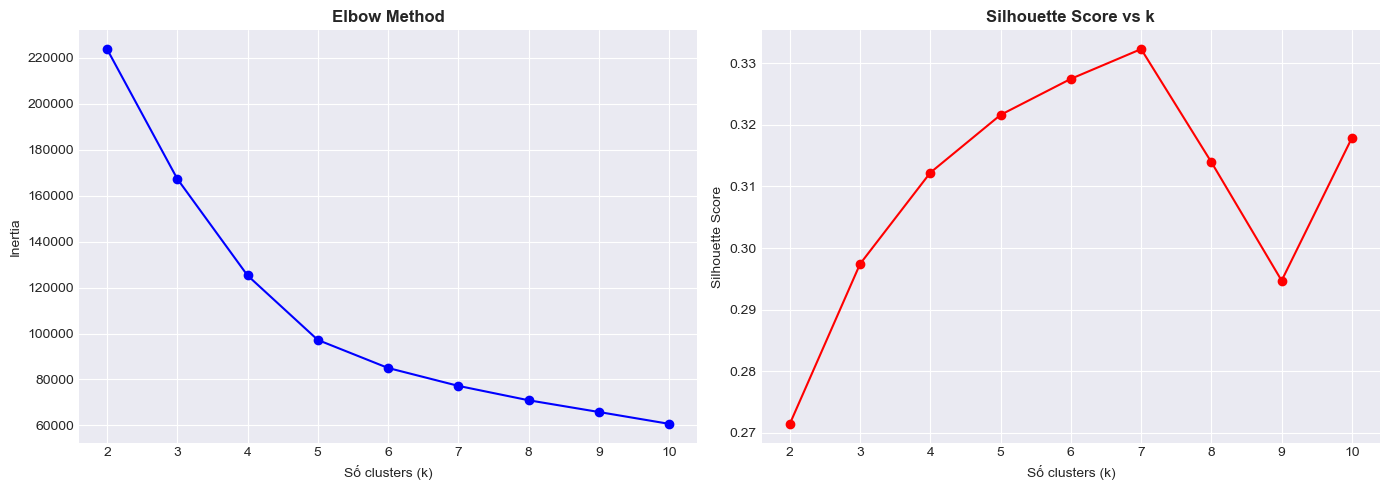

Đã lưu: figures/05_elbow_method.png
K tối ưu: 7 (Silhouette Score: 0.3323)


In [30]:
# 8.1 Elbow Method
print("1. Phương pháp Elbow - Tìm k tối ưu:")
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    # 1. Chạy KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(ram_scaled)
    inertias.append(kmeans.inertia_)
    
    # 2. Tính Silhouette (Sample 10000 dòng)
    sample_size = 10000 if len(ram_scaled) > 10000 else None
    score = silhouette_score(ram_scaled, kmeans.labels_, sample_size=sample_size, random_state=42)
    silhouette_scores.append(score)
    
    # In ra thông số
    print(f"k={k}, WCSS={kmeans.inertia_:.2f}, Silhouette={score:.4f}")

# Biểu đồ Elbow
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Số clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method', fontweight='bold')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Số clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs k', fontweight='bold')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('figures/05_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/05_elbow_method.png")

# Chọn k tối ưu (k có silhouette score cao nhất)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"K tối ưu: {optimal_k} (Silhouette Score: {max(silhouette_scores):.4f})")

#### 4.2. Huấn luyện K-Means

In [31]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
ram_df['kmeans_cluster'] = kmeans_final.fit_predict(ram_scaled)

# Đánh giá
silhouette_avg = silhouette_score(ram_scaled, ram_df['kmeans_cluster'])

print(f"  - Chỉ số Silhouette: {silhouette_avg:.4f}")


  - Chỉ số Silhouette: 0.3325


#### 4.3. Trực quan hóa các cụm K-Means

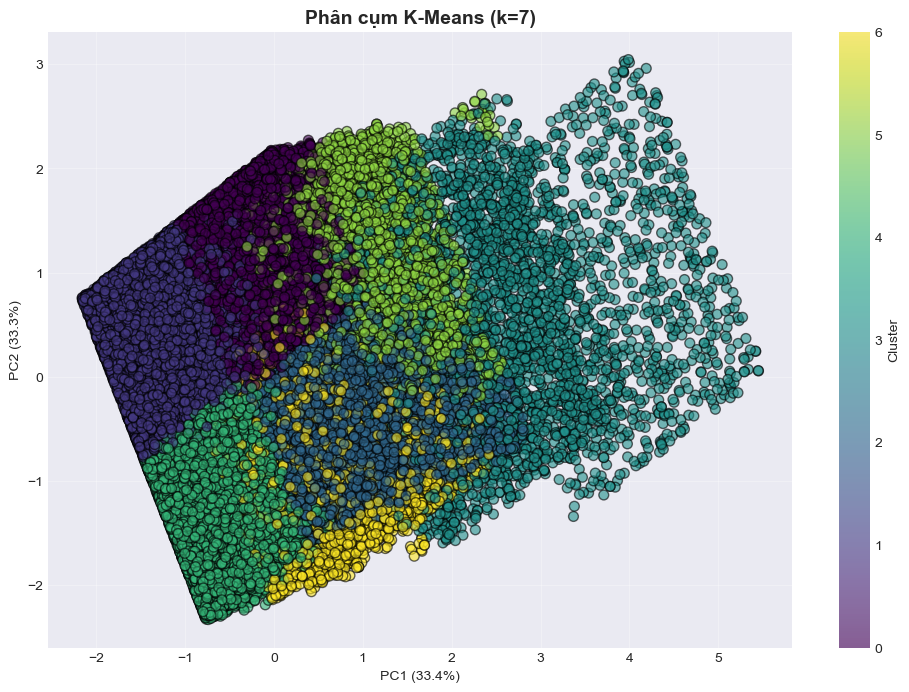

Đã lưu: figures/06_kmeans_clusters.png


In [32]:
# Giảm chiều dữ liệu RAM xuống không gian 2D bằng PCA
pca = PCA(n_components=2)
ram_pca = pca.fit_transform(ram_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(ram_pca[:, 0], ram_pca[:, 1], 
                     c=ram_df['kmeans_cluster'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     edgecolors='black',
                     s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'Phân cụm K-Means (k={optimal_k})', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.savefig('figures/06_kmeans_clusters.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/06_kmeans_clusters.png")

#### 4.4. Hồ sơ phân cụm

Thống kê theo cụm:
                   recency        age      monetary
kmeans_cluster                                     
0               591.163280  56.119531    645.195636
1               608.398303  29.799142   1287.440332
2               186.860226  57.241322   1298.060120
3               391.487044  43.352956  18288.411384
4               205.125477  30.911854    631.373749
5               557.456181  53.816819   6845.219128
6               241.649918  33.061275   6833.604103
Số lượng khách hàng mỗi cụm:
kmeans_cluster
0    19635
1    20512
2    20483
3     3975
4    20171
5     7337
6     7344
Name: count, dtype: int64


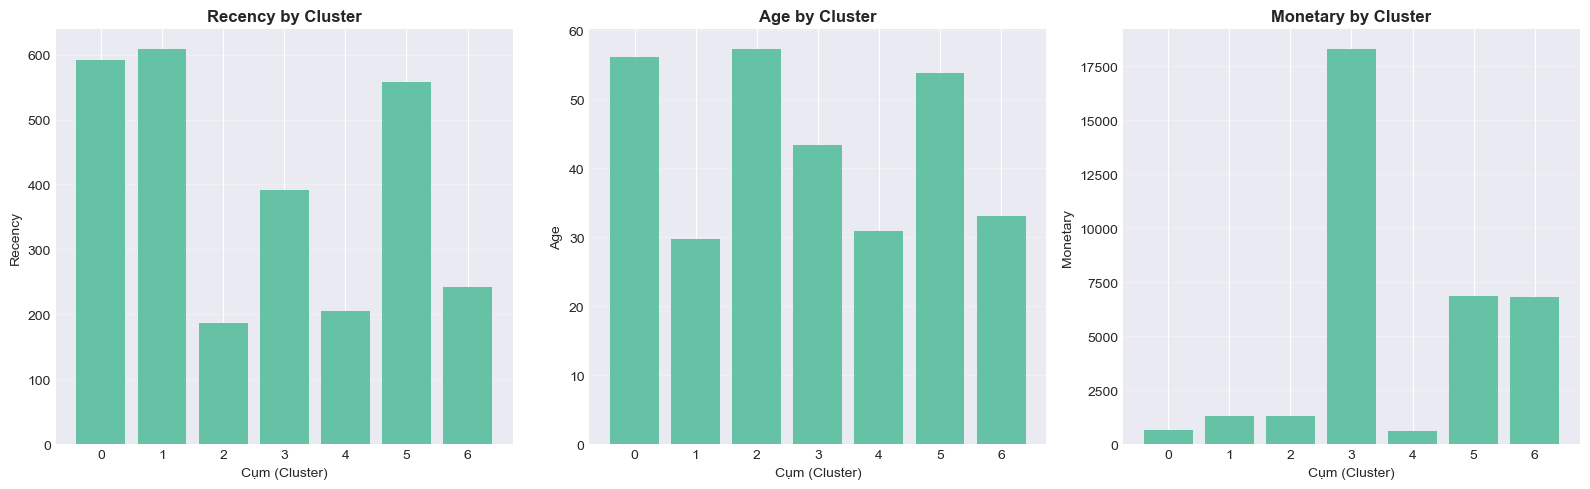

Đã lưu: figures/07_cluster_profiles_kmeans.png


In [33]:
cluster_profiles = ram_df.groupby('kmeans_cluster')[['recency', 'age', 'monetary']].mean()
cluster_sizes = ram_df['kmeans_cluster'].value_counts().sort_index()

print("Thống kê theo cụm:")
print(cluster_profiles)
print("Số lượng khách hàng mỗi cụm:")
print(cluster_sizes)

# Visualize cluster profiles
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, metric in enumerate(['recency', 'age', 'monetary']):
    axes[idx].bar(cluster_profiles.index, cluster_profiles[metric])
    axes[idx].set_xlabel('Cụm (Cluster)')
    axes[idx].set_ylabel(metric.capitalize())
    axes[idx].set_title(f'{metric.capitalize()} by Cluster', fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/07_cluster_profiles_kmeans.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/07_cluster_profiles_kmeans.png")

### 5. Phân cụm phân cấp (Hierarchical Clustering)

In [42]:
limit = 20000
np.random.seed(42)
indices = np.random.choice(len(ram_scaled), size=min(len(ram_scaled), limit), replace=False)

# Tạo các tập dữ liệu con tương ứng
ram_scaled_sub = ram_scaled[indices]
ram_pca_sub = ram_pca[indices]
ram_df_sub = ram_df.iloc[indices].copy() # Tạo bản copy để lưu kết quả


#### 5.1. Biểu đồ cây phân cụm (Dendrogram)

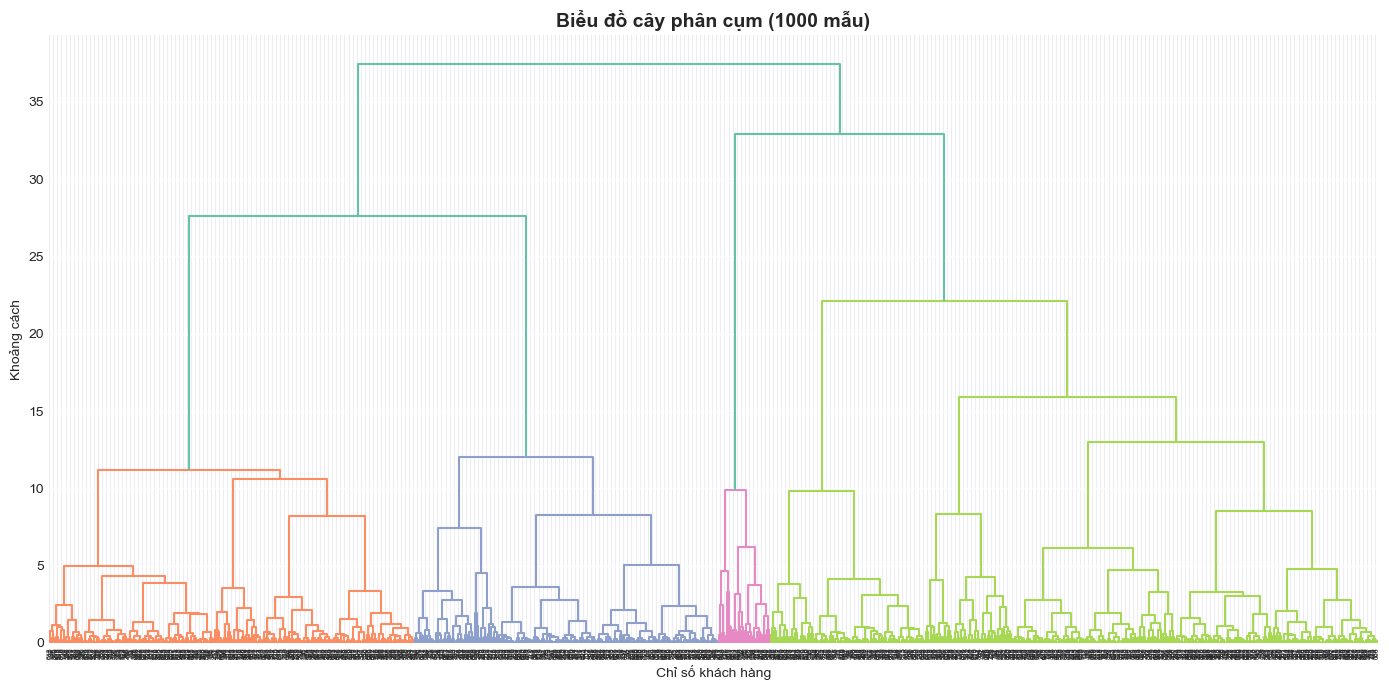

Đã lưu: figures/08_dendrogram.png


In [43]:
# Lấy mẫu nhỏ hơn (1000) chỉ để vẽ Dendrogram cho dễ nhìn
dendro_sample = ram_scaled_sub[:1000]

plt.figure(figsize=(14, 7))
linkage_matrix = linkage(dendro_sample, method='ward')
dendrogram(linkage_matrix)
plt.title('Biểu đồ cây phân cụm (1000 mẫu)', fontsize=14, fontweight='bold')
plt.xlabel('Chỉ số khách hàng')
plt.ylabel('Khoảng cách')
plt.tight_layout()
plt.savefig('figures/08_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/08_dendrogram.png")

#### 5.2. Áp dụng phân cụm phân cấp (Hierarchical Clustering)


   k=3: Chỉ số Silhouette = 0.2665
   k=4: Chỉ số Silhouette = 0.2497
   k=5: Chỉ số Silhouette = 0.2584
   k=6: Chỉ số Silhouette = 0.2549
   k=7: Chỉ số Silhouette = 0.2260
   k=8: Chỉ số Silhouette = 0.2016
   k=9: Chỉ số Silhouette = 0.2133
k tối ưu là: k = 3 (Chỉ số Silhouette: 0.2665)

   Chỉ số Silhouette (trên 20.000 mẫu): 0.2665


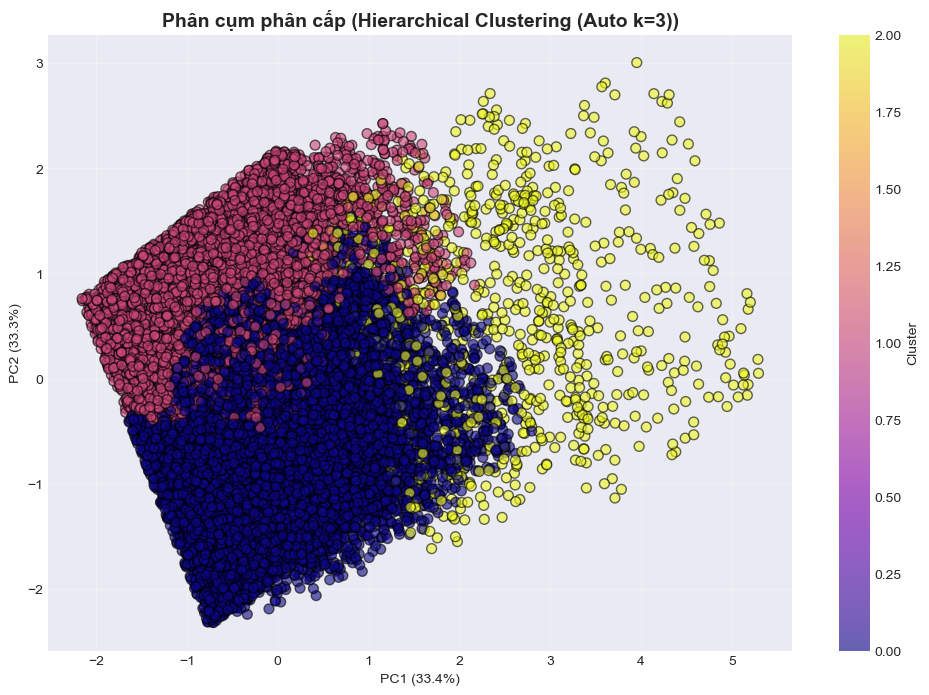

Đã lưu: figures/09_hierarchical_clusters.png


In [44]:
best_score = -1
best_k = -1
scores = []

for k_trial in range(3, 10):
    # Fit model thử nghiệm
    hc = AgglomerativeClustering(n_clusters=k_trial, linkage='ward')
    labels_trial = hc.fit_predict(ram_scaled_sub)
    
    # Tính điểm số
    score = silhouette_score(ram_scaled_sub, labels_trial)
    scores.append(score)
    print(f"   k={k_trial}: Chỉ số Silhouette = {score:.4f}")
    
    # Cập nhật nếu tìm thấy k tốt hơn
    if score > best_score:
        best_score = score
        best_k = k_trial

print(f"k tối ưu là: k = {best_k} (Chỉ số Silhouette: {best_score:.4f})")

hierarchical = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels = hierarchical.fit_predict(ram_scaled_sub)

# Lưu kết quả vào dataframe con
ram_df_sub['hierarchical_cluster'] = labels

# Đánh giá
silhouette_hier = best_score # Lấy luôn giá trị cao nhất đã tính ở trên
print(f"\n   Chỉ số Silhouette (trên 20.000 mẫu): {silhouette_hier:.4f}")

# Trực quan hóa kết quả phân cụm
plt.figure(figsize=(12, 8))
scatter = plt.scatter(ram_pca_sub[:, 0], ram_pca_sub[:, 1], 
                      c=ram_df_sub['hierarchical_cluster'], 
                      cmap='plasma', 
                      alpha=0.6,
                      edgecolors='black',
                      s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'Phân cụm phân cấp (Hierarchical Clustering (Auto k={best_k}))', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.savefig('figures/09_hierarchical_clusters.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/09_hierarchical_clusters.png")

### 6. So sánh các phương pháp phân cụm

In [47]:
ram_df.loc[ram_df_sub.index, 'hierarchical_cluster'] = ram_df_sub['hierarchical_cluster']

comparison = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical'],
    'Silhouette Score': [silhouette_avg, silhouette_hier],
    'Số lượng cụm (N_Clusters)': [optimal_k, best_k],
    'Điểm nhiễu': [0, 0]
})
print(comparison.to_string(index=False))


ram_df.to_csv('clustering_results.csv', index=False)
print("Đã lưu: clustering_results.csv (bao gồm cột hierarchical_cluster)")

      Method  Silhouette Score  Số lượng cụm (N_Clusters)  Điểm nhiễu
     K-Means          0.332542                          7           0
Hierarchical          0.266499                          3           0
Đã lưu: clustering_results.csv (bao gồm cột hierarchical_cluster)
